Statistical Method Summary:
              yaw       pitch        roll  response_time_ms     label
count   50.000000   50.000000   50.000000         50.000000  50.00000
mean    41.058800   89.001000  -23.605200        285.240000   0.70000
std    100.685119  133.217347  164.443411          0.743955   0.46291
min   -179.560000 -178.540000 -178.880000        284.000000   0.00000
25%      4.605000  141.500000 -168.792500        285.000000   0.00000
50%     88.665000  153.060000 -154.245000        285.000000   1.00000
75%    101.352500  161.382500  164.730000        286.000000   1.00000
max    170.070000  179.410000  179.980000        286.000000   1.00000

ML Method Summary:
       timestamp         yaw       pitch        roll  response_time_ms  \
count        0.0   50.000000   50.000000   50.000000          50.00000   
mean         NaN  127.093000  153.047400  -57.233800         285.26000   
std          NaN   10.702611   48.362402  157.944404           0.59966   
min          NaN   85.4100

<Figure size 1000x600 with 0 Axes>

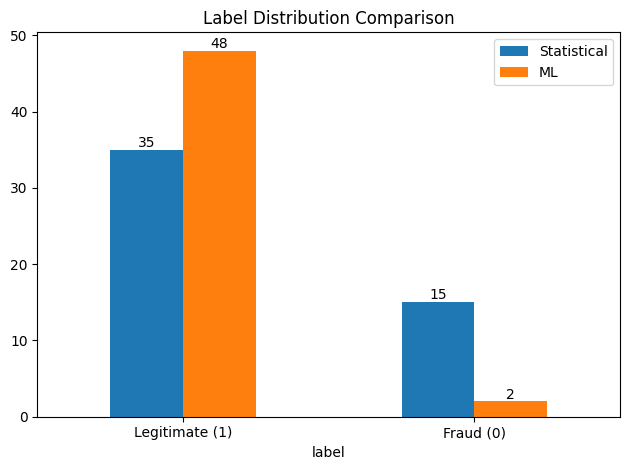

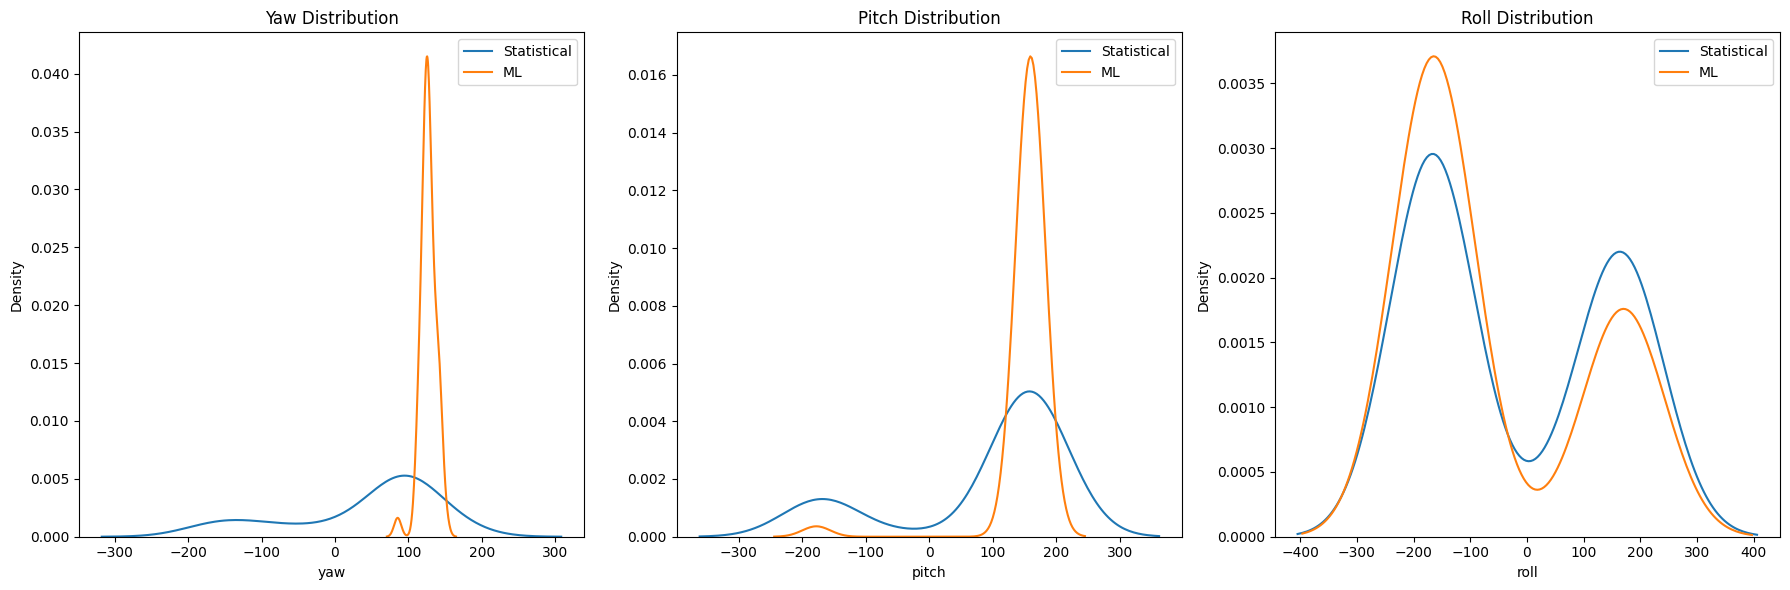

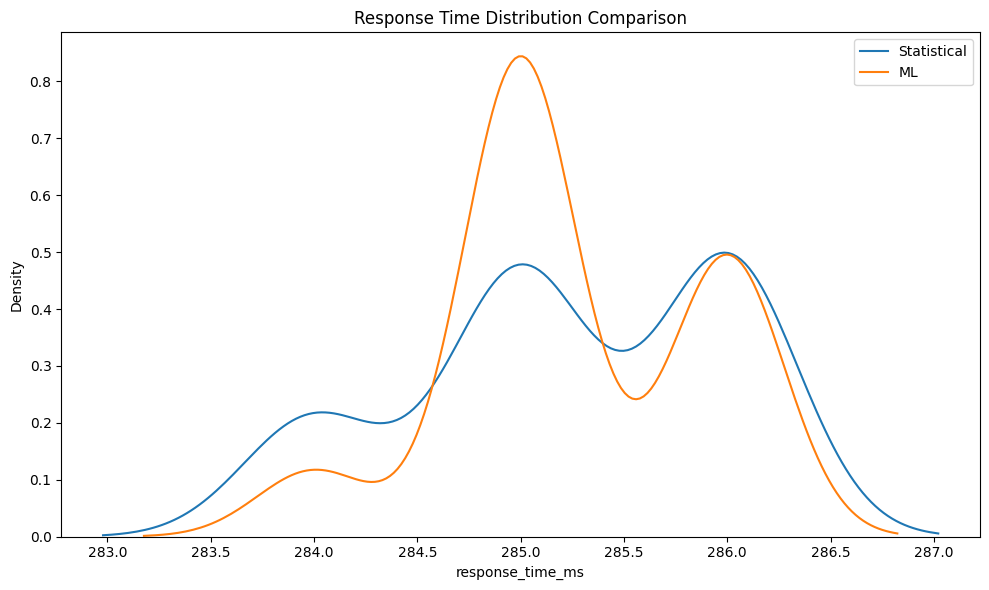

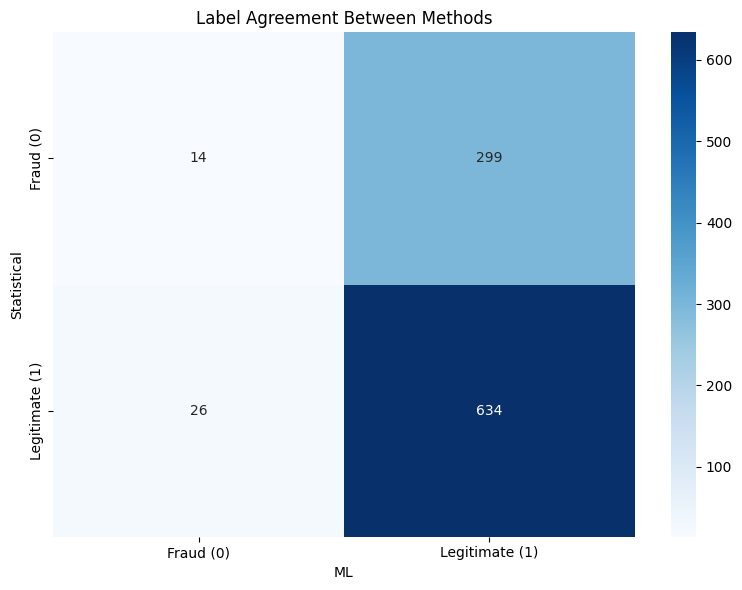


Key Metrics:
Method Agreement: 66.60%
Statistical Fraud Rate: 30.00%
ML Fraud Rate: 4.00%
Note: All values shown as counts/percentages with 0=Fraud, 1=Legitimate


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    # Explicit label encoding
    df['label'] = df['label'].apply(lambda x: 1 if any(kw in str(x).lower()
                                for kw in ['legit', 'legitimate', 'not fraud']) else 0)
    return df

def visualize_comparison(stat_df, ml_df):
    # Motion parameters subplot
    plt.figure(figsize=(18, 6))

    for i, col in enumerate(['yaw', 'pitch', 'roll'], 1):
        plt.subplot(1, 3, i)
        sns.kdeplot(stat_df[col], label='Statistical')
        sns.kdeplot(ml_df[col], label='ML')
        plt.title(f'{col.capitalize()} Distribution')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Response time comparison
    plt.figure(figsize=(10, 6))
    sns.kdeplot(stat_df['response_time_ms'], label='Statistical')
    sns.kdeplot(ml_df['response_time_ms'], label='ML')
    plt.title('Response Time Distribution Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

def analyze_results(stat_path, ml_path):
    stat_df = preprocess_data(stat_path)
    ml_df = preprocess_data(ml_path)

    # Print statistics
    print("Statistical Method Summary:")
    print(stat_df.describe())
    print("\nML Method Summary:")
    print(ml_df.describe())

    # Label distribution with values
    plt.figure(figsize=(10, 6))
    ax = pd.concat([
        stat_df['label'].value_counts().rename('Statistical'),
        ml_df['label'].value_counts().rename('ML')
    ], axis=1).plot(kind='bar')

    plt.title('Label Distribution Comparison')
    plt.xticks([1, 0], ['Fraud (0)', 'Legitimate (1)'], rotation=0)

    # Add value labels on bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=10)

    plt.tight_layout()
    plt.show()

    # Feature comparisons
    visualize_comparison(stat_df, ml_df)

    # Agreement analysis
    combined = stat_df.merge(ml_df, on='response_time_ms', suffixes=('_stat', '_ml'))
    agreement = (combined['label_stat'] == combined['label_ml']).mean()

    plt.figure(figsize=(8, 6))
    confusion_matrix = pd.crosstab(
        combined['label_stat'],
        combined['label_ml'],
        rownames=['Statistical'],
        colnames=['ML']
    )
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fraud (0)', 'Legitimate (1)'],
                yticklabels=['Fraud (0)', 'Legitimate (1)'])
    plt.title('Label Agreement Between Methods')
    plt.tight_layout()
    plt.show()

    # Final results
    print(f"\nKey Metrics:")
    print(f"Method Agreement: {agreement:.2%}")
    print(f"Statistical Fraud Rate: {1 - stat_df['label'].mean():.2%}")
    print(f"ML Fraud Rate: {1 - ml_df['label'].mean():.2%}")
    print("Note: All values shown as counts/percentages with 0=Fraud, 1=Legitimate")

analyze_results(
    stat_path='Statistical_Legit.csv',
    ml_path='ML_Legit.csv'
)


======================================== DELAY ATTACK ANALYSIS ========================================


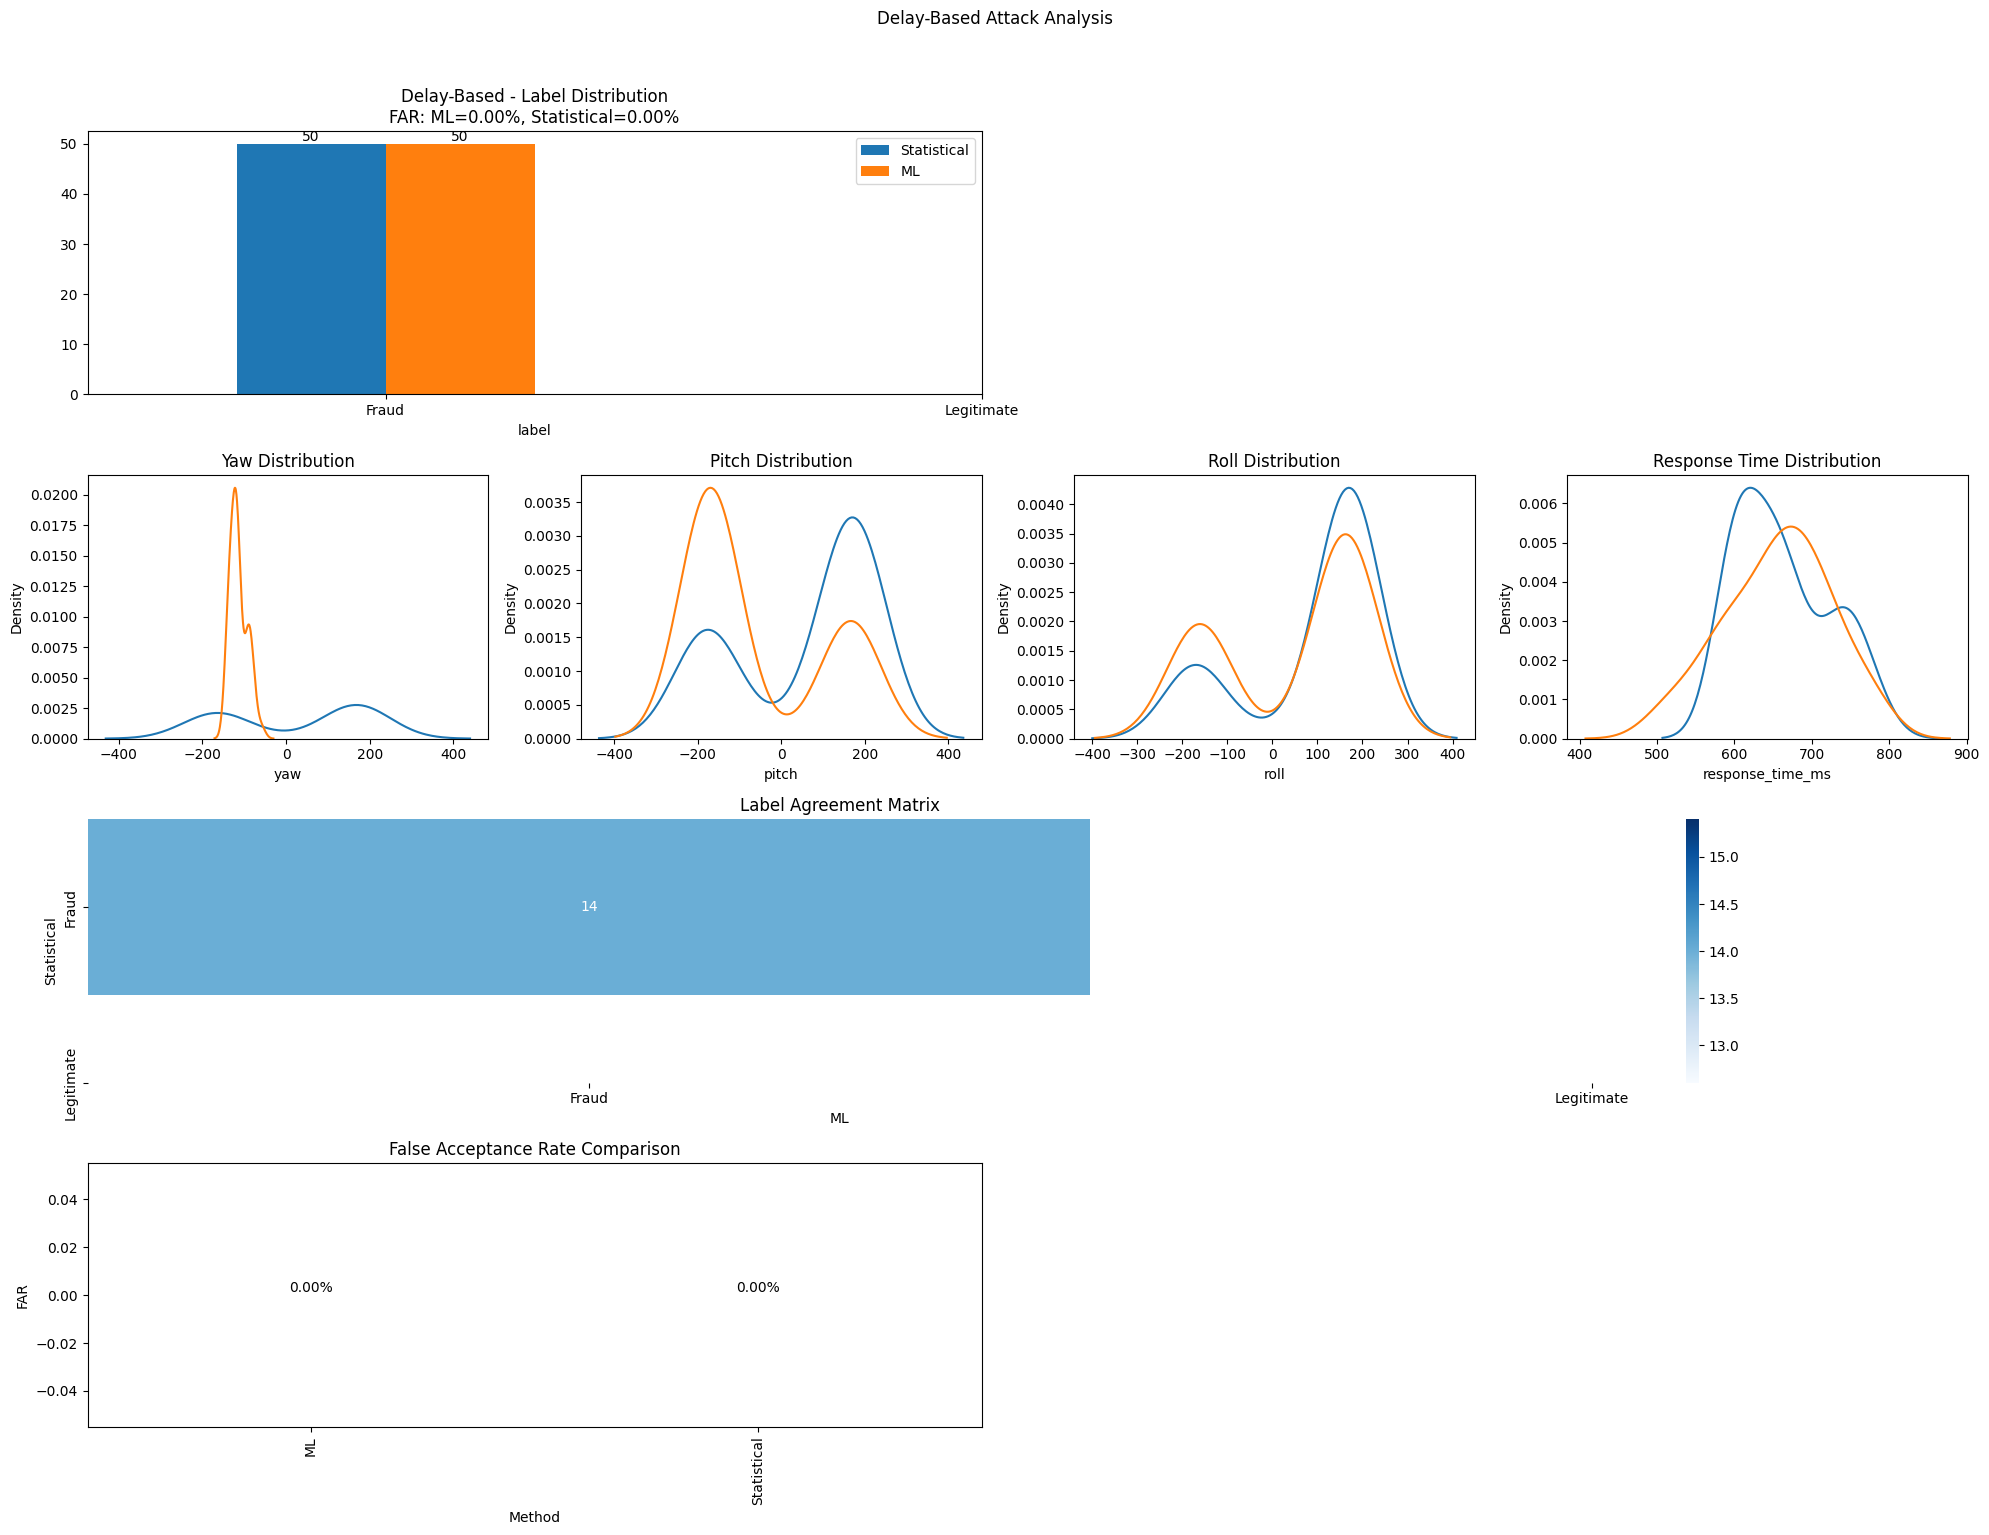


======================================== ORIENTATION ATTACK ANALYSIS ========================================


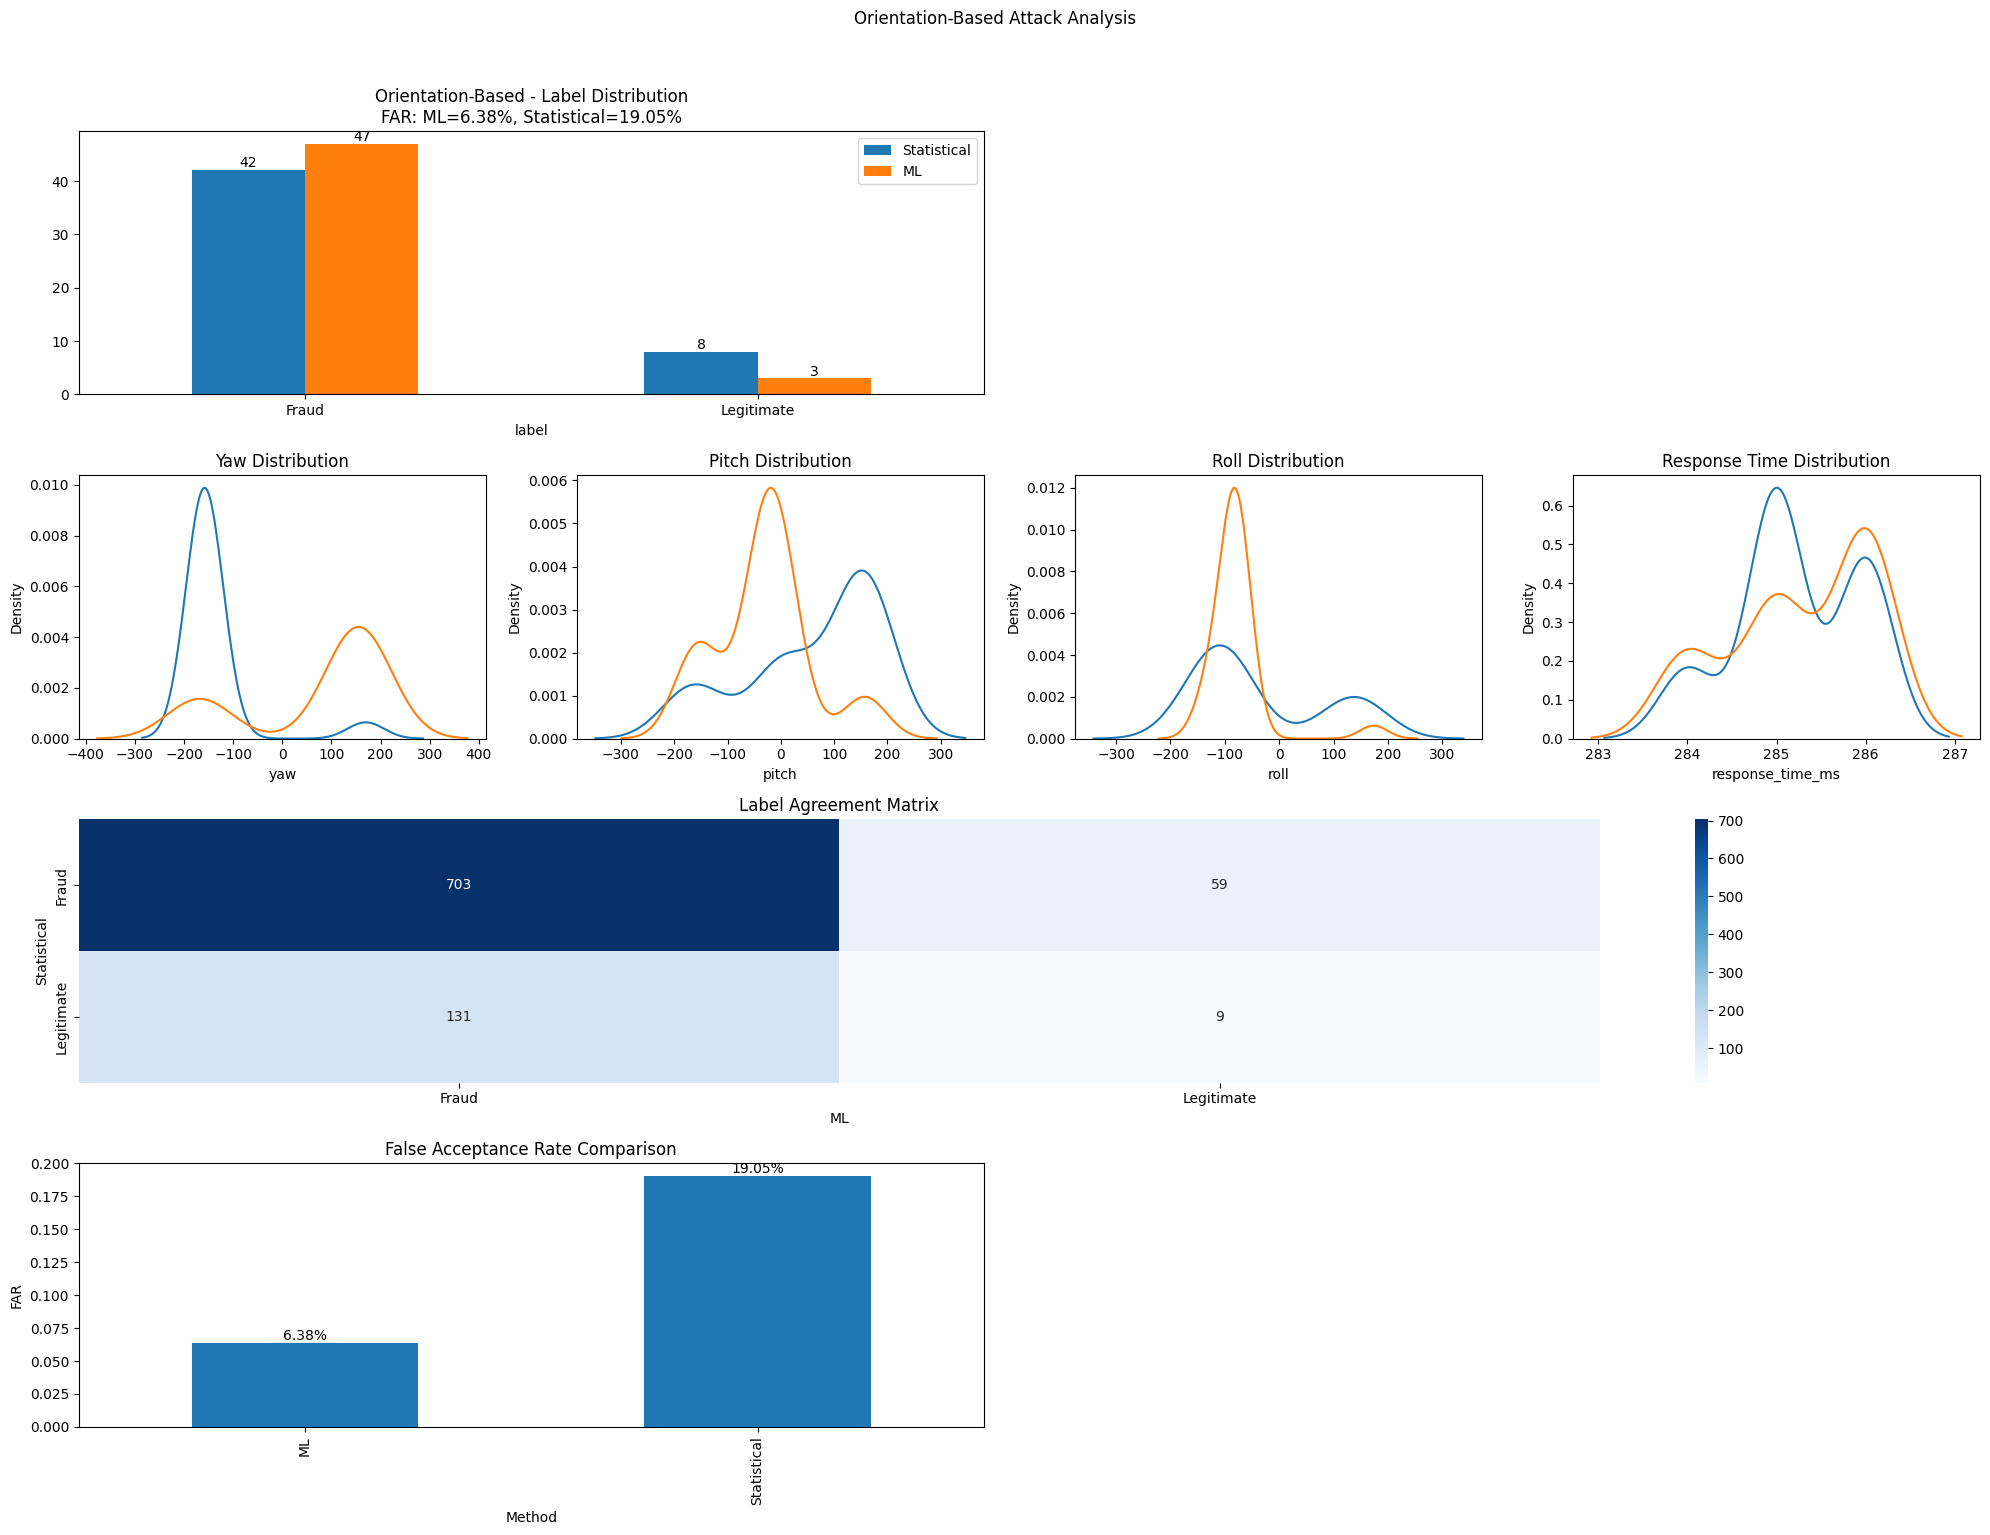


======================================== CROSS-ANALYSIS RESULTS ========================================

Comparative Statistics:
                     ML Fraud Detection Rate  \
Delay Attacks                           1.00   
Orientation Attacks                     0.94   

                     Statistical Fraud Detection Rate  ML FAR  \
Delay Attacks                                    1.00   0.000   
Orientation Attacks                              0.84   0.064   

                     Statistical FAR  Agreement Rate  Mean Response Time (ML)  \
Delay Attacks                   0.00           1.000                   655.92   
Orientation Attacks             0.19           0.789                   285.28   

                     Mean Response Time (Statistical)  
Delay Attacks                                  662.90  
Orientation Attacks                            285.22  


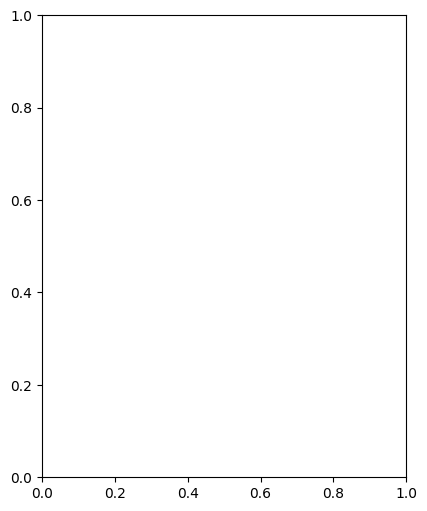

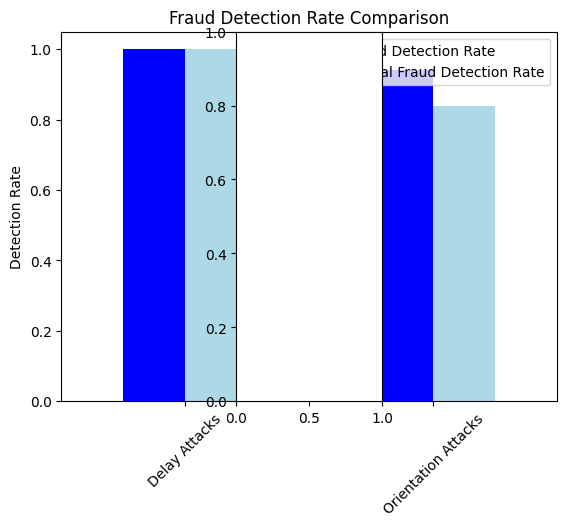

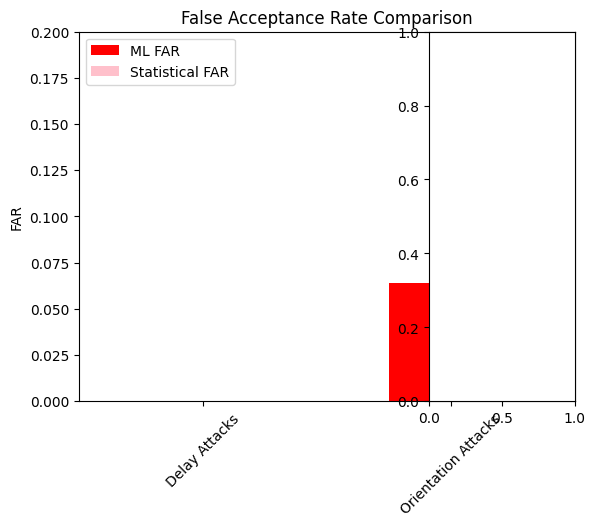

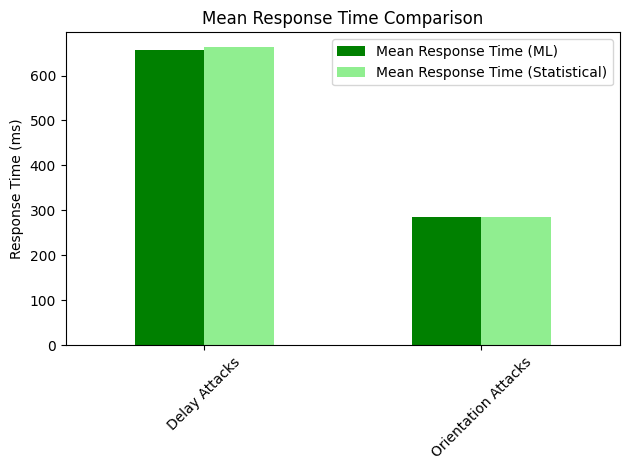

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    # Convert labels to binary (0=Fraud, 1=Legitimate)
    df['label'] = df['label'].apply(lambda x: 1 if any(kw in str(x).lower()
                                for kw in ['legit', 'legitimate', 'not fraud']) else 0)
    return df

def calculate_far(df):
    """Calculate False Acceptance Rate (FAR)"""
    total_fraud = len(df[df['label'] == 0])
    false_acceptances = len(df[(df['label'] == 1)])  # Legitimate predictions on actual frauds
    return false_acceptances / total_fraud if total_fraud > 0 else 0

def plot_attack_comparison(ml_data, stat_data, attack_type):
    plt.figure(figsize=(20, 15))
    gs = GridSpec(4, 4, figure=plt.gcf())

    # Calculate FARs
    ml_far = calculate_far(ml_data)
    stat_far = calculate_far(stat_data)

    # Label Distribution
    ax1 = plt.subplot(gs[0, :2])
    pd.concat([
        stat_data['label'].value_counts().rename('Statistical'),
        ml_data['label'].value_counts().rename('ML')
    ], axis=1).plot(kind='bar', ax=ax1)
    ax1.set_title(f'{attack_type} - Label Distribution\n'
                 f'FAR: ML={ml_far:.2%}, Statistical={stat_far:.2%}')
    ax1.set_xticks([0, 1], ['Fraud', 'Legitimate'], rotation=0)
    for p in ax1.patches:
        ax1.annotate(f'{p.get_height():.0f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 5), textcoords='offset points')

    # Motion Parameters
    for i, col in enumerate(['yaw', 'pitch', 'roll']):
        ax = plt.subplot(gs[1, i])
        sns.kdeplot(stat_data[col], label='Statistical', ax=ax)
        sns.kdeplot(ml_data[col], label='ML', ax=ax)
        ax.set_title(f'{col.capitalize()} Distribution')

    # Response Time
    ax2 = plt.subplot(gs[1, 3])
    sns.kdeplot(stat_data['response_time_ms'], label='Statistical', ax=ax2)
    sns.kdeplot(ml_data['response_time_ms'], label='ML', ax=ax2)
    ax2.set_title('Response Time Distribution')

    # Agreement Matrix
    ax3 = plt.subplot(gs[2, :])
    combined = stat_data.merge(ml_data, on='response_time_ms', suffixes=('_stat', '_ml'))
    confusion_matrix = pd.crosstab(
        combined['label_stat'],
        combined['label_ml'],
        rownames=['Statistical'],
        colnames=['ML']
    )
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fraud', 'Legitimate'],
                yticklabels=['Fraud', 'Legitimate'], ax=ax3)
    ax3.set_title('Label Agreement Matrix')

    # FAR Comparison
    ax4 = plt.subplot(gs[3, :2])
    pd.DataFrame({
        'Method': ['ML', 'Statistical'],
        'FAR': [ml_far, stat_far]
    }).plot(x='Method', y='FAR', kind='bar', ax=ax4, legend=False)
    ax4.set_title('False Acceptance Rate Comparison')
    ax4.set_ylabel('FAR')
    for p in ax4.patches:
        ax4.annotate(f'{p.get_height():.2%}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 5), textcoords='offset points')

    plt.suptitle(f'{attack_type} Attack Analysis', y=1.02)
    plt.tight_layout()
    plt.show()

    return combined

def analyze_all_datasets():
    # Load all datasets
    ml_delay = preprocess_data('ML_Relay_delay.csv')
    stat_delay = preprocess_data('Statistical_Relay_delay.csv')
    ml_orientation = preprocess_data('ML_Relay_orientation.csv')
    stat_orientation = preprocess_data('Statistical_Relay_orientation.csv')

    # Analyze delay attacks
    print("\n" + "="*40 + " DELAY ATTACK ANALYSIS " + "="*40)
    delay_combined = plot_attack_comparison(ml_delay, stat_delay, 'Delay-Based')

    # Analyze orientation attacks
    print("\n" + "="*40 + " ORIENTATION ATTACK ANALYSIS " + "="*40)
    orientation_combined = plot_attack_comparison(ml_orientation, stat_orientation, 'Orientation-Based')

    # Comparative statistics with FAR
    print("\n" + "="*40 + " CROSS-ANALYSIS RESULTS " + "="*40)
    stats = {
        'Delay Attacks': {
            'ML Fraud Detection Rate': 1 - ml_delay['label'].mean(),
            'Statistical Fraud Detection Rate': 1 - stat_delay['label'].mean(),
            'ML FAR': calculate_far(ml_delay),
            'Statistical FAR': calculate_far(stat_delay),
            'Agreement Rate': (delay_combined['label_stat'] == delay_combined['label_ml']).mean(),
            'Mean Response Time (ML)': ml_delay['response_time_ms'].mean(),
            'Mean Response Time (Statistical)': stat_delay['response_time_ms'].mean()
        },
        'Orientation Attacks': {
            'ML Fraud Detection Rate': 1 - ml_orientation['label'].mean(),
            'Statistical Fraud Detection Rate': 1 - stat_orientation['label'].mean(),
            'ML FAR': calculate_far(ml_orientation),
            'Statistical FAR': calculate_far(stat_orientation),
            'Agreement Rate': (orientation_combined['label_stat'] == orientation_combined['label_ml']).mean(),
            'Mean Response Time (ML)': ml_orientation['response_time_ms'].mean(),
            'Mean Response Time (Statistical)': stat_orientation['response_time_ms'].mean()
        }
    }

    stats_df = pd.DataFrame(stats).T
    print("\nComparative Statistics:")
    print(stats_df.round(3))

    # Visualization of key metrics
    plt.figure(figsize=(16, 6))

    # Fraud Detection Rate
    plt.subplot(1, 3, 1)
    stats_df[['ML Fraud Detection Rate', 'Statistical Fraud Detection Rate']].plot(
        kind='bar', color=['blue', 'lightblue'])
    plt.title('Fraud Detection Rate Comparison')
    plt.ylabel('Detection Rate')
    plt.xticks(rotation=45)

    # False Acceptance Rate
    plt.subplot(1, 3, 2)
    stats_df[['ML FAR', 'Statistical FAR']].plot(
        kind='bar', color=['red', 'pink'])
    plt.title('False Acceptance Rate Comparison')
    plt.ylabel('FAR')
    plt.xticks(rotation=45)

    # Response Time Comparison
    plt.subplot(1, 3, 3)
    stats_df[['Mean Response Time (ML)', 'Mean Response Time (Statistical)']].plot(
        kind='bar', color=['green', 'lightgreen'])
    plt.title('Mean Response Time Comparison')
    plt.ylabel('Response Time (ms)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Run complete analysis
analyze_all_datasets()

In [ ]:
import scipy.stats as stats

# Create a contingency table
observed = [[35, 15],
            [48, 2]]

chi2, p, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-squared: {chi2:.4f}, p-value: {p:.4f}")


Chi-squared: 10.2055, p-value: 0.0014


“A Chi-square test of independence was conducted to assess whether model type significantly influenced detection outcomes. The results were statistically significant, χ²(1, N = 100) = 10.2025, p = 0.0014, significantly lower than 0.05, indicating that prediction accuracy was dependent on the choice of detection model.”


In [ ]:
import scipy.stats as stats

# Create a contingency table
observed1 = [[127, 23],
            [145, 5]]

chi2, p, dof, expected = stats.chi2_contingency(observed1)

print(f"Chi-squared: {chi2:.4f}, p-value: {p:.4f}")


Chi-squared: 11.3839, p-value: 0.0007


In [ ]:
# prompt: calculate the mean and standard deviation of the pitch and roll values from the file ML_Legit.csv where label is legit. use absolute for the values before calculating

import pandas as pd

def analyze_legit_data(file_path):
    legit_df = pd.read_csv(file_path)
    # Filter for legitimate samples
    # legit_df = df[df['label'].str.lower().str.contains('legit')]

    # Calculate absolute values
    legit_df['pitch'] = abs(legit_df['pitch'])
    legit_df['roll'] = abs(legit_df['roll'])

    # Calculate mean and standard deviation
    pitch_mean = legit_df['pitch'].mean()
    pitch_std = legit_df['pitch'].std()
    roll_mean = legit_df['roll'].mean()
    roll_std = legit_df['roll'].std()

    print(f"Pitch Mean: {pitch_mean:.2f}")
    print(f"Pitch Standard Deviation: {pitch_std:.2f}")
    print(f"Roll Mean: {roll_mean:.2f}")
    print(f"Roll Standard Deviation: {roll_std:.2f}")

analyze_legit_data('ML_Legit.csv')


Pitch Mean: 160.15
Pitch Standard Deviation: 8.28
Roll Mean: 166.16
Roll Standard Deviation: 10.82


In [ ]:
# prompt: calculate the mean and standard deviation of the pitch and roll values from the file ML_Legit.csv where label is legit. use absolute for the values before calculating

import pandas as pd

def analyze_legit_data(file_path):
    legit_df = pd.read_csv(file_path)
    # Filter for legitimate samples
    # legit_df = df[df['label'].str.lower().str.contains('legit')]

    # Calculate absolute values
    legit_df['pitch'] = abs(legit_df['pitch'])
    legit_df['roll'] = abs(legit_df['roll'])

    # Calculate mean and standard deviation
    pitch_mean = legit_df['pitch'].mean()
    pitch_std = legit_df['pitch'].std()
    roll_mean = legit_df['roll'].mean()
    roll_std = legit_df['roll'].std()

    print(f"Pitch Mean: {pitch_mean:.2f}")
    print(f"Pitch Standard Deviation: {pitch_std:.2f}")
    print(f"Roll Mean: {roll_mean:.2f}")
    print(f"Roll Standard Deviation: {roll_std:.2f}")

analyze_legit_data('Statistical_Legit.csv')


Pitch Mean: 157.60
Pitch Standard Deviation: 22.02
Roll Mean: 162.92
Roll Standard Deviation: 22.92


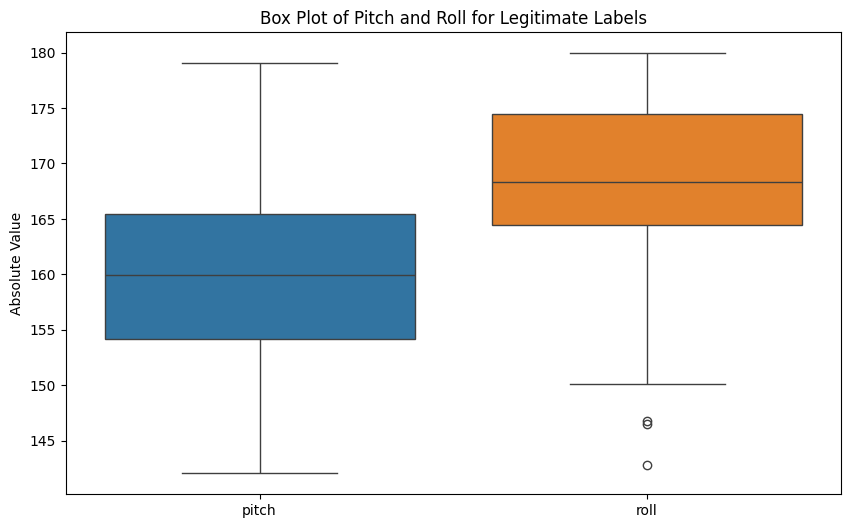

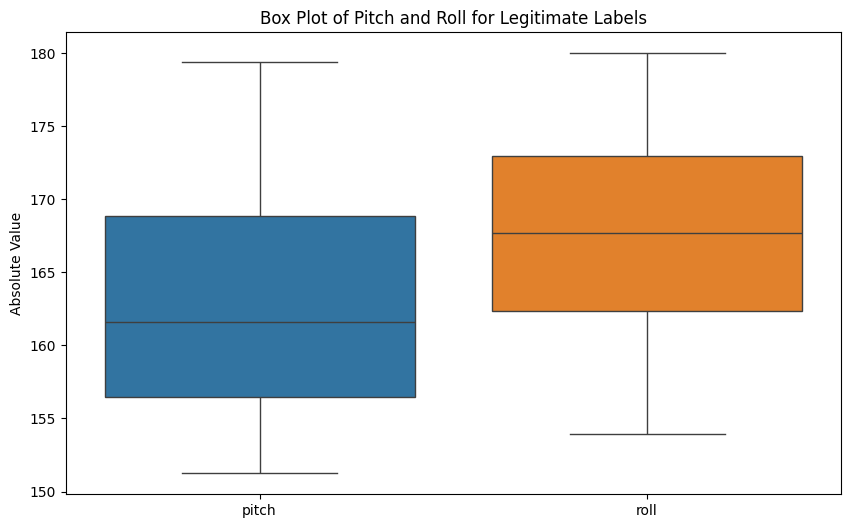

In [ ]:
# prompt: further visualize the pitch and roll of the accepted or legit label using box plot. use only the lables that's legit

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_legit_data(file_path):
    legit_df = pd.read_csv(file_path)

    # Filter for legitimate samples based on label
    legit_df['label'] = legit_df['label'].apply(lambda x: 1 if any(kw in str(x).lower()
                                for kw in ['legit', 'legitimate', 'not fraud']) else 0)
    legit_df = legit_df[legit_df['label'] == 1]

    # Calculate absolute values of pitch and roll
    legit_df['pitch'] = abs(legit_df['pitch'])
    legit_df['roll'] = abs(legit_df['roll'])

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=legit_df[['pitch', 'roll']])
    plt.title('Box Plot of Pitch and Roll for Legitimate Labels')
    plt.ylabel('Absolute Value')
    plt.show()

analyze_legit_data('ML_Legit.csv')
analyze_legit_data('Statistical_Legit.csv')


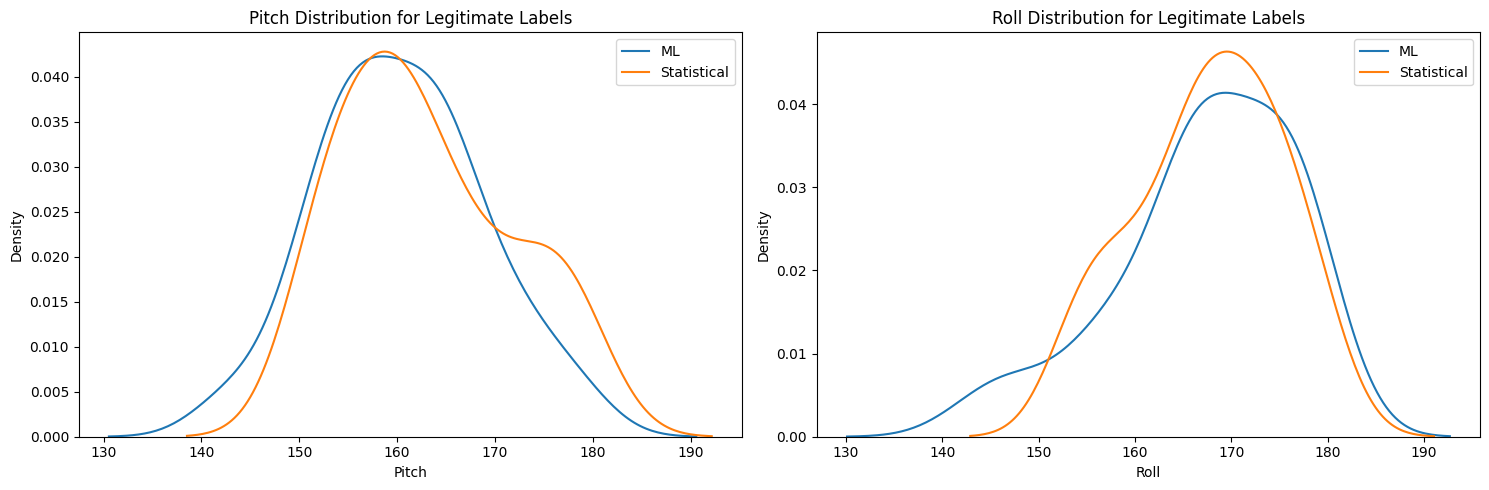

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_legit_data(file_path, method_name):
    legit_df = pd.read_csv(file_path)

    # Filter for legitimate samples based on label
    legit_df['label'] = legit_df['label'].apply(lambda x: 1 if any(kw in str(x).lower()
                                for kw in ['legit', 'legitimate', 'not fraud']) else 0)
    legit_df = legit_df[legit_df['label'] == 1]

    # Calculate absolute values of pitch and roll
    legit_df['pitch'] = abs(legit_df['pitch'])
    legit_df['roll'] = abs(legit_df['roll'])

    return legit_df

# Analyze both datasets
ml_legit_df = analyze_legit_data('ML_Legit.csv', 'ML')
stat_legit_df = analyze_legit_data('Statistical_Legit.csv', 'Statistical')

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Pitch Plot
# Instead of 'density', use the actual column name for the y-axis (e.g., 'pitch')
sns.kdeplot(x='pitch', data=ml_legit_df, ax=axes[0], label='ML')
sns.kdeplot(x='pitch', data=stat_legit_df, ax=axes[0], label='Statistical')
axes[0].set_title('Pitch Distribution for Legitimate Labels')
axes[0].set_xlabel("Pitch")
axes[0].set_ylabel("Density")  # You can keep the y-axis label as "Density" if appropriate
axes[0].legend()

# Roll Plot
# Instead of 'density', use the actual column name for the y-axis (e.g., 'roll')
sns.kdeplot(x='roll', data=ml_legit_df, ax=axes[1], label='ML')
sns.kdeplot(x='roll', data=stat_legit_df, ax=axes[1], label='Statistical')
axes[1].set_title('Roll Distribution for Legitimate Labels')
axes[1].set_xlabel("Roll")
axes[1].set_ylabel("Density")  # You can keep the y-axis label as "Density" if appropriate
axes[1].legend()

plt.tight_layout()
plt.show()

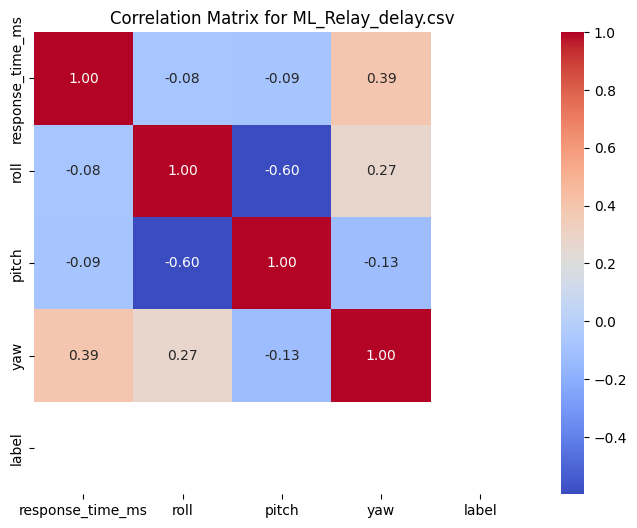

In [ ]:
# prompt: check the correlations of the headers. only use response_time_ms, roll, pitch, yaw, label . use ML_Relay_delay. use a heat matrix. convert the lable to 0 or 1 iu

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['label'] = df['label'].apply(lambda x: 1 if any(kw in str(x).lower()
                                for kw in ['legit', 'legitimate', 'not fraud']) else 0)
    return df

def analyze_correlations(file_path):
    df = preprocess_data(file_path)
    # Select specific columns for correlation analysis
    cols_to_analyze = ['response_time_ms', 'roll', 'pitch', 'yaw', 'label']
    correlation_matrix = df[cols_to_analyze].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for {file_path}')
    plt.show()

# Analyze ML_Relay_delay.csv
analyze_correlations('ML_Relay_delay.csv')


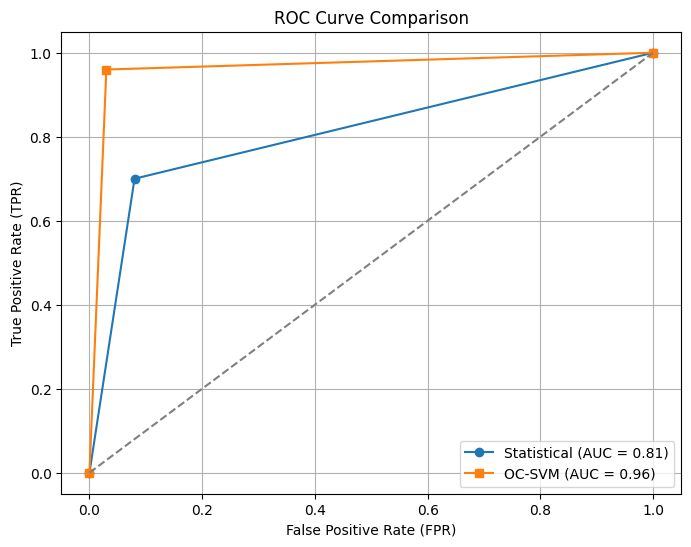

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Model 1 values
fpr1 = [0, 0.08, 1]  # Starting from (0,0) to (FPR, TPR) to (1,1)
tpr1 = [0, 0.70, 1]

# Model 2 values
fpr2 = [0, 0.03, 1]
tpr2 = [0, 0.96, 1]

# Calculate AUC for each model
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

# Plotting
plt.figure(figsize=(8,6))
plt.plot(fpr1, tpr1, marker='o', label=f'Statistical (AUC = {auc1:.2f})')
plt.plot(fpr2, tpr2, marker='s', label=f'OC-SVM (AUC = {auc2:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()
